## For testing only on fMRI data without EEG
replacing train file, still calling functions in engine and model

In [1]:
import os
import time
import pickle
import torch

import numpy as np
import scipy.sparse as sp
from scipy.sparse import linalg
from scipy.signal import butter,filtfilt, zpk2sos, sosfilt
from scipy.stats.stats import pearsonr
from sklearn.utils import shuffle

from Utils import graphTools
from Utils import dataTools
from Utils.CRASH_loader import *
from Utils.util import *
from engine import *

import ipdb
from tqdm import tqdm

In [2]:
np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

''' args '''
# data and processing configs
adjtype = 'transition'
addaptadj = True
randomadj = True
aptonly = False
gcn_bool = True
scatter = False

tasks = ['rest','VWM-1','VWM-2','VWM-3','DYN-1','DYN-2','DYN-3','DYN-4','DOT','MOD','PVT']
task = tasks[0]
savedir = './garage/CRASH_'+task

# model params
in_dim = 1
nhid = 32
kernel_size = 2
blocks = 4
layers = 2
# input length 40: B4-L2; 50: B5-L2

# training params
dropout = 0.3
learning_rate = 3e-4
weight_decay = 8e-3
batch_size = 64
epochs = 50
print_every = 100
device = torch.device('cuda:0')

## 1. Data

### load data

In [3]:
comn_ids = get_comn_ids(F_only=True)
num_region = 200 # 200 or 400
sc = get_sc(comn_ids, num_region)
fmri = get_fmri(comn_ids, num_region, task)

 27%|██▋       | 15/56 [00:00<00:00, 145.31it/s]

loading SC


  4%|▎         | 2/56 [00:00<00:04, 12.80it/s]

loading fMRI


100%|██████████| 56/56 [00:02<00:00, 19.54it/s]


In [4]:
# print fmri shape
for k in fmri:
    if k!= 'time_res':
        for j in fmri[k]:
            print(fmri[k][j].shape)

(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)
(326, 200)

### put data into matrices and process

In [5]:
if task == tasks[0]:
    fmri_len = 326
    cut_out = 2
elif task == tasks[1] or task == tasks[2] or task == tasks[3]:
    fmri_len = 302
    cut_out = 2
elif task == tasks[4]:
    fmri_len = 277
    cut_out = 12
elif task == tasks[9]:
    fmri_len = 833
    cut_out = 0

scs = []
fmri_mat = []
adjs = []
for subj in comn_ids:
    for ses in fmri[subj]:
        if ses in sc[subj] and len(fmri[subj][ses]) >= fmri_len:
            scs.append(sc[subj][ses])
            adjs.append(mod_adj(sc[subj][ses], adjtype))
            fmri_mat.append(fmri[subj][ses][cut_out:fmri_len]) # removing the first several frames since they tend to spike

scs = np.stack(scs)
fmri_mat = np.stack(fmri_mat)

print(scs.shape)
print(fmri_mat.shape)

(244, 200, 200)
(244, 324, 200)


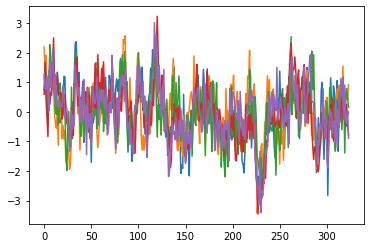

In [6]:
for i in range(15,20):
    plt.plot(fmri_mat[0,:,i])
plt.show()

In [7]:
# only use the sessions without huge spikes: thresholding at 6
valid_idx = []
for i in range(len(fmri_mat)):
    if np.abs(fmri_mat[i]).max() < 6 : 
        valid_idx.append(i)
#     else: # to visualize invalid ones
#         for j in range(200):
#             plt.plot(fmri_mat[i,:,j])
#         plt.show()

print('valid sessions:', len(valid_idx))

# only keep valid ones
fmri_mat = fmri_mat[valid_idx]
scs = scs[valid_idx]
adjs = [adjs[i] for i in valid_idx]

valid sessions: 208


### choose whether low-pass filter fMRI or not

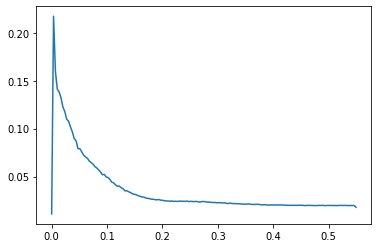

most fMRI f: 0.0033916700583367246 Hz, aka 1/ 294.84000000000003 s


In [8]:
''' plot fmri signal in freq domain '''
xf = np.fft.rfftfreq(fmri_mat.shape[1], d=0.91) # up to nyquist freq: 1/2*(1/0.91)
yf = np.zeros_like(xf)
for i in range(len(fmri_mat)):
    for j in range(fmri_mat.shape[-1]):
        tmp = fmri_mat[i, :, j]
        yf += np.abs(np.fft.rfft(tmp) / len(tmp))

yf /= (fmri_mat.shape[0]*fmri_mat.shape[-1])
plt.plot(xf, yf)
plt.show()
highest_f_component = xf[np.where(yf == max(yf))[0][0]]
print('most fMRI f:', highest_f_component, 'Hz, aka 1/', 1/highest_f_component, 's')

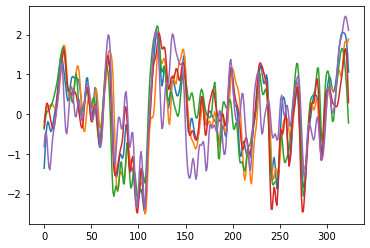

In [9]:
''' low pass filter fMRI with 0.2 hz threshold '''
if task == tasks[0] or task == tasks[4]:
    cutoff = 0.2 #(1/0.91)/(2*3)
elif task == tasks[1] or task == tasks[2]:
    cutoff = 0.25

for i in range(fmri_mat.shape[0]): #fmri_mat: (n, t, 200)
    for j in range(fmri_mat.shape[-1]):
        fmri_mat[i,:,j] = butter_lowpass_filter(fmri_mat[i,:,j], cutoff, 1/0.91)

for i in range(5):
    plt.plot(fmri_mat[0,:,i])
plt.show()

### sliding window to create x-y pairs

In [28]:
### same input - output length

window_len = 10
f_stride = 1 # sliding window stride
F_idxer = np.arange(window_len)[None, :] + np.arange(0, fmri_mat.shape[1] - window_len + 1, f_stride)[:, None]
# print(F_idxer)

x_idxer = F_idxer[:-window_len]
y_idxer = F_idxer[window_len:]
print(x_idxer)
print(y_idxer)

_input = fmri_mat[:, x_idxer, :]
_gt = fmri_mat[:, y_idxer, :]
print(_input.shape)
_input = _input.reshape(-1, *_input.shape[2:])
_gt = _gt.reshape(-1, *_gt.shape[2:])
print(_input.shape)

[[  0   1   2 ...   7   8   9]
 [  1   2   3 ...   8   9  10]
 [  2   3   4 ...   9  10  11]
 ...
 [302 303 304 ... 309 310 311]
 [303 304 305 ... 310 311 312]
 [304 305 306 ... 311 312 313]]
[[ 10  11  12 ...  17  18  19]
 [ 11  12  13 ...  18  19  20]
 [ 12  13  14 ...  19  20  21]
 ...
 [312 313 314 ... 319 320 321]
 [313 314 315 ... 320 321 322]
 [314 315 316 ... 321 322 323]]
(208, 305, 10, 200)
(63440, 10, 200)


In [10]:
### input longer than output

window_len_x = 20
window_len_y = 1
f_stride = 1 # sliding window stride

x_idxer = np.arange(window_len_x)[None, :] + np.arange(0, fmri_mat.shape[1] - window_len_x + 1, f_stride)[:, None]
x_idxer = x_idxer[:-window_len_y]
print(x_idxer)


y_idxer = np.arange(window_len_y)[None, :] + np.arange(0, fmri_mat.shape[1] - window_len_y + 1, f_stride)[:, None]
y_idxer = y_idxer[window_len_x:]
print(y_idxer)

print(x_idxer.shape, y_idxer.shape)

_input = fmri_mat[:, x_idxer, :]
_gt = fmri_mat[:, y_idxer, :]
print(_input.shape, _gt.shape)
_input = _input.reshape(-1, *_input.shape[2:])
_gt = _gt.reshape(-1, *_gt.shape[2:])
print(_input.shape, _gt.shape)

[[  0   1   2 ...  17  18  19]
 [  1   2   3 ...  18  19  20]
 [  2   3   4 ...  19  20  21]
 ...
 [301 302 303 ... 318 319 320]
 [302 303 304 ... 319 320 321]
 [303 304 305 ... 320 321 322]]
[[ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 76]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 87]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [101]
 [102]
 [103]
 [104]
 [105]
 [106]
 [107]
 [108]
 [109]
 [110]
 [111]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [1

In [11]:
'''randomize SC entries to see the sensitivity to SC'''
if False:
    import networkx as nx
    # use completely random SC w/ same level of sparsity
    n = _input.shape[-1] # number of nodes
    p = np.count_nonzero(adj_mx[0][0]) / (n*(n-1)/2) # probability for edge creation
    _G = nx.gnp_random_graph(n, p)
    # _G = nx.newman_watts_strogatz_graph(n,5,p)
    # _G = nx.gnm_random_graph(n, np.count_nonzero(adj_mx[0][0]))
    for i in range(len(adj_mx)):
        # _G = nx.gnp_random_graph(n, p)
        adj_mx[i] = mod_adj(nx.to_numpy_matrix(_G), adjtype)

In [12]:
def proc_helper(a, b, len_adj, no_scaler=False):
    assert len(a) == len(b), 'input length do not match'
    assert len(a) % len_adj == 0

    # deal with adj_mx repetitions (using idx)
    adj_mx_idx = np.arange(len_adj).repeat(len(a)//len_adj)
    # shuffle for mixing different subjects' image
    adj_mx_idx, a, b = shuffle(adj_mx_idx, a, b, random_state = 0)
    # train-val-test split
    num_total = len(a)
    nTrain = round(0.7 * num_total)
    nValid = round(0.15 * num_total)
    nTest = num_total - nTrain - nValid
    print('Train, Val, Test numbers:', nTrain, nValid, nTest)

    if no_scaler:
        return nTrain, nValid, nTest, a, b, None, None, adj_mx_idx
    
    # # overall scaler
    # scaler_a = util.StandardScaler(mean=a[:nTrain].mean(), std=a[:nTrain].std())
    # a = scaler_a.transform(a)
    ### TODO: fmri alone can only use train data for the scaler, revise here

    # per-feature standardization
    scaler_a = StandardScaler(a.mean((0,1)), a.std((0,1)))
    
    a = scaler_a.transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
    return nTrain, nValid, nTest, a, b, scaler_a, adj_mx_idx

In [13]:
nTrain, nValid, nTest, _input, _gt, scaler_x, adj_mx_idx = proc_helper(_input, _gt, len(adjs))

Train, Val, Test numbers: 44262 9485 9485


### adj related init

In [14]:
# separate adj matrices into train-val-test samples
# ipdb.set_trace() # shuffle adj to test rand adj's influence

_adj = [[] for i in range(len(adjs[0]))]
for a in adjs:
    for i in range(len(_adj)):
        _adj[i].append(a[i])
adjs = [np.stack(np.asarray(i)) for i in _adj]

supports = {}
supports['train'] = supports['val'] = supports['test'] = adjs

adjinit = None
if addaptadj:
    adjinit = {}
    if randomadj:
        adjinit['train'] = adjinit['val'] = adjinit['test'] = None
    else:
        adjinit['train'] = np.concatenate([adjs[c][0][None,...] for c in adj_mx_idx[:nTrain]]) 
        adjinit['val'] = np.concatenate([adjs[c][0][None,...] for c in adj_mx_idx[nTrain:-nTest]])
        adjinit['test'] = np.concatenate([adjs[c][0][None,...] for c in adj_mx_idx[-nTest:]])

    if aptonly:
        supports = None

## 2. Training and validation

### create engine

In [15]:
engine = trainer(scaler_x, in_dim, window_len_x, _input.shape[-1], nhid, 
                 dropout, learning_rate, weight_decay, device, 
                 supports, gcn_bool, addaptadj, adjinit, kernel_size,
                 blocks, layers, out_nodes=_gt.shape[-1], F_t=window_len_x/window_len_y,
                 subsample=False, F_only=True, batch_size=batch_size)

gwnet_vgae(
  (filter_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (1): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (2): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (3): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (4): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (5): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (6): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (7): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
  )
  (gate_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (1): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (2): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (3): Conv1d(32, 32, kernel_size=(1

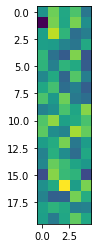

In [16]:
plt.imshow(engine.model.nodevec.detach().cpu().numpy())

### train-val loop

In [17]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'os', 'time', 'pickle', 'torch', 'np', 'sp', 'linalg', 'butter', 'filtfilt', 'zpk2sos', 'sosfilt', 'pearsonr', 'shuffle', 'graphTools', 'dataTools', 'glob', 'spio', 'nib', 'plt', 'ipdb', 'tqdm', 'base_d', 'eeg_d', 'fmri_d', 'fmri_bold_d', 'sc_d', 'loadmat', 'show_slices', 'checkIsAP', 'closest_idx', 'get_eeg', 'get_fmri_bold', 'get_fmri', 'get_sc', 'get_comn_ids', 'get_region_assignment', 'DataLoader', 'DataLoader_syn', 'StandardScaler', 'sym_adj', 'asym_adj', 'calculate_normalized_laplacian', 'calculate_scaled_laplacian', 'load_pickle', 'mod_adj', 'load_adj', 'load_dataset_metr', 'load_dataset_syn', 'load_dataset_CRASH', 'inverse_sliding_window', 'masked_mse', 'masked_rmse', 'masked_mae', 'masked_mape', 'metric', 'butter_lowpass_filter', 'get_cc', 'optim', 'nn', 'F', 'mat

In [ ]:
print("start training...",flush=True)

his_loss_train = []
his_loss_val =[]
val_time = []
train_time = []
min_loss = float('Inf')
grads = []

for i in range(1, epochs+1):
    # if i % 50 == 0:
    #     # lr = max(0.000002, learning_rate * (0.1 ** (i // 10)))
    #     for g in engine.optimizer.param_groups:
    #         g['lr'] *= 0.9

    train_loss = []
    train_mae = []
    train_mape = []
    train_rmse = []
    t1 = time.time()
    engine.set_state('train')
    x = _input[:nTrain]
    y = _gt[:nTrain]
    adj_idx = adj_mx_idx[:nTrain]
    if scatter:
        _coeffs = coeffs[:nTrain]

    # # for overfitting
    # x = _input
    # y = _gt
    # adj_idx = adj_mx_idx
    # if scatter:
    #     _coeffs = coeffs

    iter = 0
    # shuffle in-out-adj_idx
    if addaptadj:
        if not randomadj:
            # adjinit['train'] need to be shuffled with train set
            if scatter:
                x, y, adj_idx, _coeffs, adjinit['train'] = shuffle(x, y, adj_idx, _coeffs, adjinit['train'])
            else:
                x, y, adj_idx, adjinit['train'] = shuffle(x, y, adj_idx, adjinit['train'])
    else:
        if scatter:
            x, y, adj_idx, _coeffs = shuffle(x, y, adj_idx, _coeffs)
        else:
            x, y, adj_idx = shuffle(x, y, adj_idx)

    # shuffle y, to test if model really learns anything (~random output)
    # y = shuffle(y)

    for batch_i in range(nTrain//batch_size):
        _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
        _x = torch.Tensor(x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]).to(device).transpose(1, 3)
        if scatter:
            # _y = y[batch_i * args.batch_size: (batch_i + 1) * args.batch_size]
            # coeff_y = torch.Tensor(scattering(_y.transpose(0,2,1))).to(device)
            # _y = torch.Tensor(_y).to(device)
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)
            coeff_y  = torch.Tensor(_coeffs[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

            _y = [_y.transpose(1,2), coeff_y]
        else:
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

        metrics = engine.train_CRASH(_x, _y, None, {}, _adj_idx) # region assignment temporarily use {}, TODO: pooling

        train_loss.append(metrics[0])
        train_mae.append(metrics[1])
        train_mape.append(metrics[2])
        train_rmse.append(metrics[3])
        # grads.append(metrics[4])
        if iter % print_every == 0 :
            log = 'Iter: {:03d}, Train Loss: {:.6f}, Train MAE: {:.4f}, Train MAPE: {:.4f}, Train RMSE: {:.4f}'
            print(log.format(iter, train_loss[-1], train_mae[-1], train_mape[-1], train_rmse[-1]),flush=True)
        iter += 1
        # break # overfit single batch

    t2 = time.time()
    train_time.append(t2-t1)

    #validation
    valid_loss = []
    valid_mae = []
    valid_mape = []
    valid_rmse = []
    valid_cc = []

    s1 = time.time()
    engine.set_state('val')
    x = _input[nTrain:nTrain+nValid]
    y = _gt[nTrain:nTrain+nValid]
    adj_idx = adj_mx_idx[nTrain:nTrain+nValid]
    if scatter:
        _coeffs = coeffs[nTrain:nTrain+nValid]

    # # for overfitting
    # x = _input
    # y = _gt
    # adj_idx = adj_mx_idx
    # if scatter:
    #     _coeffs = coeffs

    for batch_i in range(nValid//batch_size):
        _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
        _x = torch.Tensor(x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]).to(device).transpose(1, 3)
        if scatter:
            # _y = y[batch_i * args.batch_size: (batch_i + 1) * args.batch_size]
            # coeff_y = torch.Tensor(scattering(_y.transpose(0,2,1))).to(device)
            # _y = torch.Tensor(_y).to(device)
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)
            coeff_y  = torch.Tensor(_coeffs[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

            _y = [_y.transpose(1,2), coeff_y]
        else:
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

        if batch_i == 0: # only viz the first one
            metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx, viz=False)
        else:
            metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx)
        valid_loss.append(metrics[0])
        valid_mae.append(metrics[1])
        valid_mape.append(metrics[2])
        valid_rmse.append(metrics[3])
        valid_cc.append(metrics[4])

        # plt.plot(metrics[-1][...,order0,:][0,0,0,0].cpu().numpy())
        # plt.show()
        #     break # overfit single batch
        # break

    s2 = time.time()
    log = 'Epoch: {:03d}, Inference Time: {:.4f} secs'
    print(log.format(i,(s2-s1)))
    val_time.append(s2-s1)

    mtrain_loss = np.mean(train_loss)
    mtrain_mae = np.mean(train_mae)
    mtrain_mape = np.mean(train_mape)
    mtrain_rmse = np.mean(train_rmse)

    mvalid_loss = np.mean(valid_loss)
    mvalid_mae = np.mean(valid_mae)
    mvalid_mape = np.mean(valid_mape)
    mvalid_rmse = np.mean(valid_rmse)
    mvalid_cc = np.mean(valid_cc)
    his_loss_train.append(mtrain_loss)
    his_loss_val.append(mvalid_loss)

    log = 'Epoch: {:03d}, Train Loss: {:.6f}, Train MAE: {:.4f}, Train MAPE: {:.4f}, Train RMSE: {:.4f}, Valid Loss: {:.6f}, Valid MAE: {:.4f}, Valid MAPE: {:.4f}, Valid RMSE: {:.4f}, Valid CC: {:.4f}, Training Time: {:.4f}/epoch'
    print(log.format(i, mtrain_loss, mtrain_mae, mtrain_mape, mtrain_rmse, mvalid_loss, mvalid_mae, mvalid_mape, mvalid_rmse, mvalid_cc, (t2 - t1)),flush=True)
    # only save the best
    if mvalid_loss < min_loss:
        min_loss = mvalid_loss
        # # remove previous
        # fname = glob.glob(savedir+'_epoch_*.pth')
        # for f in fname:
        #     os.remove(f)
        # save new
        torch.save(engine.model.state_dict(), savedir+"_epoch_"+str(i)+"_"+str(round(mvalid_loss,2))+".pth")
    # torch.save(engine.model.state_dict(), savedir+"_epoch_"+str(i)+"_"+str(round(mvalid_loss,2))+".pth")
print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
print("Average Inference Time: {:.4f} secs".format(np.mean(val_time))) 

start training...
Iter: 000, Train Loss: 1692806283264.000000, Train MAE: 880511.5000, Train MAPE: -5865290.0000, Train RMSE: 1301078.8750
Iter: 100, Train Loss: 11095454720.000000, Train MAE: 68077.1094, Train MAPE: -253954.0781, Train RMSE: 105334.9609
Iter: 200, Train Loss: 0.847821, Train MAE: 0.7294, Train MAPE: -0.4238, Train RMSE: 0.9208
Iter: 300, Train Loss: 0.865711, Train MAE: 0.7359, Train MAPE: -0.0746, Train RMSE: 0.9304
Iter: 400, Train Loss: 0.792190, Train MAE: 0.7042, Train MAPE: -0.1170, Train RMSE: 0.8901
Iter: 500, Train Loss: 0.671082, Train MAE: 0.6565, Train MAPE: -0.0459, Train RMSE: 0.8192
Iter: 600, Train Loss: 0.731718, Train MAE: 0.6743, Train MAPE: 0.0637, Train RMSE: 0.8554


/home/sikun/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Epoch: 001, Inference Time: 13.0061 secs
Epoch: 001, Train Loss: 30831523204.929203, Train MAE: 45622.8566, Train MAPE: -206149.8351, Train RMSE: 65813.3653, Valid Loss: 0.820983, Valid MAE: 0.7199, Valid MAPE: 0.0600, Valid RMSE: 0.9050, Valid CC: nan, Training Time: 109.9223/epoch
Iter: 000, Train Loss: 0.875206, Train MAE: 0.7501, Train MAPE: -0.1146, Train RMSE: 0.9355
Iter: 100, Train Loss: 0.750086, Train MAE: 0.6994, Train MAPE: 0.1390, Train RMSE: 0.8661
Iter: 200, Train Loss: 0.827547, Train MAE: 0.7178, Train MAPE: -0.0337, Train RMSE: 0.9097
Iter: 300, Train Loss: 0.856944, Train MAE: 0.7329, Train MAPE: 0.0422, Train RMSE: 0.9257
Iter: 400, Train Loss: 0.787727, Train MAE: 0.7017, Train MAPE: -0.0232, Train RMSE: 0.8875
Iter: 500, Train Loss: 0.669833, Train MAE: 0.6553, Train MAPE: 0.0734, Train RMSE: 0.8184
Iter: 600, Train Loss: 0.733789, Train MAE: 0.6747, Train MAPE: 0.0896, Train RMSE: 0.8566
Epoch: 002, Inference Time: 12.9759 secs
Epoch: 002, Train Loss: 0.810913, T

Iter: 000, Train Loss: 0.872974, Train MAE: 0.7492, Train MAPE: -0.1339, Train RMSE: 0.9343
Iter: 100, Train Loss: 0.750241, Train MAE: 0.6995, Train MAPE: 0.1204, Train RMSE: 0.8662
Iter: 200, Train Loss: 0.827031, Train MAE: 0.7175, Train MAPE: -0.0225, Train RMSE: 0.9094
Iter: 300, Train Loss: 0.856606, Train MAE: 0.7327, Train MAPE: 0.0376, Train RMSE: 0.9255
Iter: 400, Train Loss: 0.788136, Train MAE: 0.7017, Train MAPE: -0.0211, Train RMSE: 0.8878
Iter: 500, Train Loss: 0.669840, Train MAE: 0.6554, Train MAPE: 0.0777, Train RMSE: 0.8184
Iter: 600, Train Loss: 0.733567, Train MAE: 0.6747, Train MAPE: 0.1146, Train RMSE: 0.8565
Epoch: 011, Inference Time: 12.9428 secs
Epoch: 011, Train Loss: 0.810922, Train MAE: 0.7152, Train MAPE: -0.0702, Train RMSE: 0.8995, Valid Loss: 0.820850, Valid MAE: 0.7198, Valid MAPE: 0.0972, Valid RMSE: 0.9050, Valid CC: nan, Training Time: 109.8867/epoch
Iter: 000, Train Loss: 0.873296, Train MAE: 0.7493, Train MAPE: -0.1455, Train RMSE: 0.9345
Iter: 1

Iter: 100, Train Loss: 0.750705, Train MAE: 0.6997, Train MAPE: 0.1228, Train RMSE: 0.8664
Iter: 200, Train Loss: 0.827584, Train MAE: 0.7179, Train MAPE: -0.0290, Train RMSE: 0.9097
Iter: 300, Train Loss: 0.856911, Train MAE: 0.7327, Train MAPE: 0.0669, Train RMSE: 0.9257
Iter: 400, Train Loss: 0.787733, Train MAE: 0.7018, Train MAPE: -0.0222, Train RMSE: 0.8875
Iter: 500, Train Loss: 0.669683, Train MAE: 0.6552, Train MAPE: 0.0226, Train RMSE: 0.8183
Iter: 600, Train Loss: 0.733850, Train MAE: 0.6748, Train MAPE: 0.0937, Train RMSE: 0.8567
Epoch: 020, Inference Time: 12.9465 secs
Epoch: 020, Train Loss: 0.810921, Train MAE: 0.7152, Train MAPE: -0.2156, Train RMSE: 0.8995, Valid Loss: 0.820850, Valid MAE: 0.7198, Valid MAPE: 0.0969, Valid RMSE: 0.9050, Valid CC: nan, Training Time: 109.7741/epoch
Iter: 000, Train Loss: 0.873493, Train MAE: 0.7494, Train MAPE: -0.1435, Train RMSE: 0.9346
Iter: 100, Train Loss: 0.750158, Train MAE: 0.6996, Train MAPE: 0.1066, Train RMSE: 0.8661
Iter: 20

Iter: 200, Train Loss: 0.827112, Train MAE: 0.7177, Train MAPE: -0.0236, Train RMSE: 0.9095
Iter: 300, Train Loss: 0.857363, Train MAE: 0.7329, Train MAPE: 0.0748, Train RMSE: 0.9259
Iter: 400, Train Loss: 0.787604, Train MAE: 0.7016, Train MAPE: -0.0186, Train RMSE: 0.8875
Iter: 500, Train Loss: 0.669698, Train MAE: 0.6553, Train MAPE: 0.0703, Train RMSE: 0.8184
Iter: 600, Train Loss: 0.734031, Train MAE: 0.6748, Train MAPE: 0.1217, Train RMSE: 0.8568
Epoch: 029, Inference Time: 12.9087 secs
Epoch: 029, Train Loss: 0.810902, Train MAE: 0.7152, Train MAPE: 0.0519, Train RMSE: 0.8995, Valid Loss: 0.820845, Valid MAE: 0.7198, Valid MAPE: 0.0994, Valid RMSE: 0.9050, Valid CC: nan, Training Time: 109.6290/epoch
Iter: 000, Train Loss: 0.873499, Train MAE: 0.7492, Train MAPE: -0.0639, Train RMSE: 0.9346
Iter: 100, Train Loss: 0.751101, Train MAE: 0.7000, Train MAPE: 0.1042, Train RMSE: 0.8667
Iter: 200, Train Loss: 0.826764, Train MAE: 0.7175, Train MAPE: -0.0061, Train RMSE: 0.9093
Iter: 30

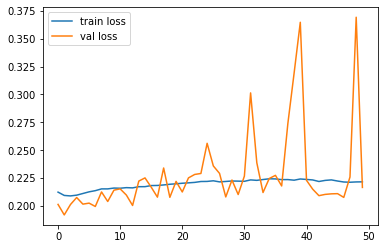

In [22]:
plt.plot(his_loss_train, label='train loss')
plt.plot(his_loss_val, label='val loss')
plt.legend()
plt.show()
# ipdb.set_trace() #tmp1 = [i[0] for i in grads] # plot his_loss_train and his_loss_val
his_loss = his_loss_val

## 3. testing and visualizations

### loading pretrained models if any

In [18]:
model_name = 'garage/CRASH_rest_epoch_9_0.19.pth'
pretrained_dict = torch.load(model_name)

model_dict = engine.model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
engine.model.load_state_dict(model_dict)

<All keys matched successfully>

### direct testing (multistep output from model)

  0%|          | 0/131 [00:00<?, ?it/s]

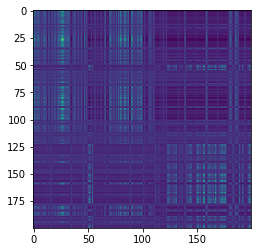

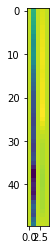

> /home/sikun/Documents/Graph-WaveNet/model.py(849)forward()
    848 
--> 849             if len(supports) > 0:
    850                 new_supports = supports + [adp]

ipdb> self.nodevec.shape
torch.Size([50, 5])
ipdb> self.nodevec.sum(0).shape
torch.Size([5])
ipdb> self.nodevec.sum(1)
tensor([-0.0085, -0.0089, -0.0091, -0.0092, -0.0094, -0.0102, -0.0114, -0.0123,
        -0.0123, -0.0117, -0.0112, -0.0117, -0.0132, -0.0150, -0.0166, -0.0175,
        -0.0180, -0.0187, -0.0196, -0.0205, -0.0210, -0.0210, -0.0208, -0.0210,
        -0.0218, -0.0229, -0.0236, -0.0238, -0.0239, -0.0247, -0.0261, -0.0274,
        -0.0274, -0.0262, -0.0256, -0.0274, -0.0315, -0.0350, -0.0353, -0.0331,
        -0.0315, -0.0322, -0.0329, -0.0306, -0.0259, -0.0233, -0.0247, -0.0253,
        -0.0207, -0.0182], device='cuda:0')
ipdb> c


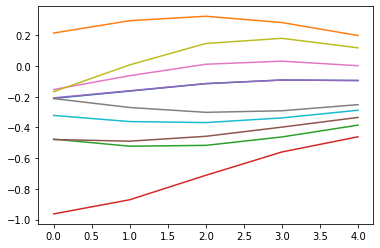

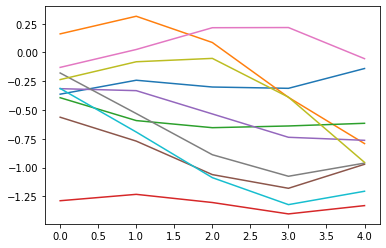

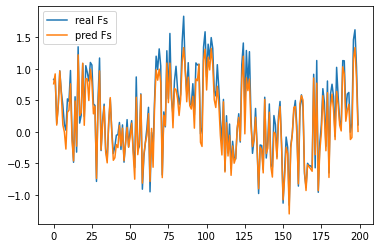

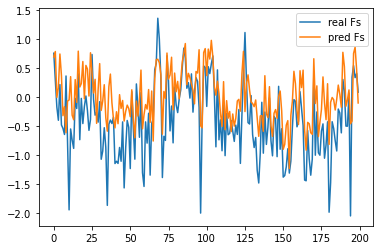

> <ipython-input-23-92c106cac3ec>(19)<module>()
     18 
---> 19 for batch_i in tqdm(range(nTest//batch_size)):
     20     _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]

ipdb> c


100%|██████████| 131/131 [08:17<00:00,  3.80s/it] 


In [23]:
# testing
amae = []
amape = []
armse = []
a_cc = []

real_Fs = []
pred_Fs = []
pred_coeffs = []
adpa = []

engine.set_state('test')
x = _input[-nTest:]
y = _gt[-nTest:]
adj_idx = adj_mx_idx[-nTest:]
if scatter:
    _coeffs = coeffs[-nTest:]

for batch_i in tqdm(range(nTest//batch_size)):
    _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
    _x = torch.Tensor(x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]).to(device).transpose(1, 3)
    if scatter:
        # _y = y[batch_i * args.batch_size: (batch_i + 1) * args.batch_size]
        # coeff_y = torch.Tensor(scattering(_y.transpose(0,2,1))).to(device)
        # _y = torch.Tensor(_y).to(device)
        _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)
        coeff_y  = torch.Tensor(_coeffs[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

        _y = [_y.transpose(1,2), coeff_y]
    else:
        _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

    if batch_i == 0: # only viz the first one
        metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx, viz=True)
    else:
        metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx)

    amae.append(metrics[1])
    amape.append(metrics[2])
    armse.append(metrics[3])
    adpa.append(metrics[5])

    real_Fs.append(_y)
    pred_Fs.append(metrics[-3])
    
    if scatter:
        pred_coeffs.append(metrics[-1])

    if batch_i == 0:
        if scatter:
            # for in-network scatter checking
            # ipdb.set_trace()
            plt.figure('sig')
            plt.plot(real_Es[0][0].squeeze().cpu().numpy()[1,1], label='real')
            plt.plot(pred_Es[0].squeeze().cpu().numpy()[1,1], label='pred')
            plt.legend()
            # plt.savefig('sig.png')

            plt.figure('coeff')
            # plt.plot(real_Es[0][1].squeeze().cpu().numpy()[0,0], label='real')
            # plt.plot(pred_coeffs[0].squeeze().cpu().numpy()[0,0], label='pred')
            plt.plot(real_Es[0][1].squeeze().cpu().numpy()[1,1,0], label='real')
            plt.plot(pred_coeffs[0].squeeze().cpu().numpy()[1,1,0], label='pred')
            plt.legend()
            # plt.savefig('coeff.png')
            plt.show()
            ipdb.set_trace()   

        else:
            plt.figure(0) # timestep 0
            plt.plot(real_Fs[0].squeeze().cpu().numpy()[3,0], label='real Fs')
            plt.plot(pred_Fs[0].squeeze().cpu().numpy()[3,0], label='pred Fs')
            plt.legend()
            plt.show()
            plt.figure(1) # timestep 3
            plt.plot(real_Fs[0].squeeze().cpu().numpy()[3,3], label='real Fs')
            plt.plot(pred_Fs[0].squeeze().cpu().numpy()[3,3], label='pred Fs')
            plt.legend()
            plt.show()                       
            ipdb.set_trace()

In [25]:
torch.cat(adpa).cpu().numpy().shape

(8384, 200, 200)

In [26]:
np.save('adaptive_adj_F_'+task+'longIN.npy', torch.cat(adpa).cpu().numpy())

### Recursively predict / generate the next frame

In [ ]:
# testing
test

amae = []
amape = []
armse = []
a_cc = []

real_Fs = []
pred_Fs = []
pred_coeffs = []
adpa = []

engine.set_state('test')
x = _input[-nTest:]
y = _gt[-nTest:]
adj_idx = adj_mx_idx[-nTest:]
if scatter:
    _coeffs = coeffs[-nTest:]

for batch_i in tqdm(range(nTest//batch_size)):
    _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
    _x = torch.Tensor(x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]).to(device).transpose(1, 3)
    if scatter:
        # _y = y[batch_i * args.batch_size: (batch_i + 1) * args.batch_size]
        # coeff_y = torch.Tensor(scattering(_y.transpose(0,2,1))).to(device)
        # _y = torch.Tensor(_y).to(device)
        _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)
        coeff_y  = torch.Tensor(_coeffs[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

        _y = [_y.transpose(1,2), coeff_y]
    else:
        
        _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

    if batch_i == 0: # only viz the first one
        metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx, viz=True)
    else:
        metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx)

    amae.append(metrics[1])
    amape.append(metrics[2])
    armse.append(metrics[3])
    adpa.append(metrics[5])

    real_Fs.append(_y)
    pred_Fs.append(metrics[-3])
    
    if scatter:
        pred_coeffs.append(metrics[-1])

    if batch_i == 0:
        if scatter:
            # for in-network scatter checking
            # ipdb.set_trace()
            plt.figure('sig')
            plt.plot(real_Es[0][0].squeeze().cpu().numpy()[1,1], label='real')
            plt.plot(pred_Es[0].squeeze().cpu().numpy()[1,1], label='pred')
            plt.legend()
            # plt.savefig('sig.png')

            plt.figure('coeff')
            # plt.plot(real_Es[0][1].squeeze().cpu().numpy()[0,0], label='real')
            # plt.plot(pred_coeffs[0].squeeze().cpu().numpy()[0,0], label='pred')
            plt.plot(real_Es[0][1].squeeze().cpu().numpy()[1,1,0], label='real')
            plt.plot(pred_coeffs[0].squeeze().cpu().numpy()[1,1,0], label='pred')
            plt.legend()
            # plt.savefig('coeff.png')
            plt.show()
            ipdb.set_trace()   

        else:
            plt.figure(0) # timestep 0
            plt.plot(real_Fs[0].squeeze().cpu().numpy()[3,0], label='real Fs')
            plt.plot(pred_Fs[0].squeeze().cpu().numpy()[3,0], label='pred Fs')
            plt.legend()
            plt.show()
            plt.figure(1) # timestep 3
            plt.plot(real_Fs[0].squeeze().cpu().numpy()[3,3], label='real Fs')
            plt.plot(pred_Fs[0].squeeze().cpu().numpy()[3,3], label='pred Fs')
            plt.legend()
            plt.show()                       
            ipdb.set_trace()